In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Data_Loader import sort_data
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from Data_Loader import load_data
from Train2 import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader
dtype = torch.FloatTensor


In [2]:
from Data_extraction_lung import data_norm_df_lung, output_df_lung

data_norm_df_lung= data_norm_df_lung.reset_index(drop=True)
output_df_lung = output_df_lung.reset_index(drop=True)

In [3]:
data = pd.concat([data_norm_df_lung,output_df_lung], axis=1)
x, ytime, yevent, age = load_data(data, dtype)

In [4]:
x, ytime, yevent, age = sort_data(data)
x = StandardScaler().fit_transform(x)
pca = PCA(100)
pca.fit(x)
x = pca.transform(x)

In [5]:
from sksurv.ensemble import RandomSurvivalForest

# x, ytime, yevent, age = sort_data(data)
# x = StandardScaler().fit_transform(x)


x_df=pd.DataFrame(x, columns = np.arange(len(x[0,:])))
data_rf = pd.concat([x_df,pd.DataFrame({'age': age[:,0], 'yevent': yevent[:,0], 'ytime': ytime[:,0]})], axis=1)
data_rf['yevent']= [bool(k) for k in data_rf['yevent']]

In [6]:
from sklearn.model_selection import KFold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
c_index_rf = []
for fold,(train_idx,test_idx) in enumerate(kfold.split(data_rf)):
    random_forest = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf = 15)
    data_train = data_rf.loc[train_idx].reset_index( drop = True )
    data_test  = data_rf.loc[test_idx].reset_index( drop = True )

    # Creating the X, T and E input
    X_train, X_test = data_train.drop(['ytime','yevent'], axis=1), data_test.drop(['ytime','yevent'], axis=1)
    y_train, y_test = data_train[['yevent','ytime']].to_numpy(), data_test[['yevent','ytime']].to_numpy()
    #List of tuples
    aux_train = [(e1,e2) for e1,e2 in y_train]
    aux_test = [(e1,e2) for e1,e2 in y_test]

    #Structured array
    y_train, y_test = np.array(aux_train, dtype=[('Status', '?'), ('Survival_in_days', '<f8')]), np.array(aux_test, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    random_forest.fit(X_train, y_train)
    c_index_rf.append(random_forest.score(X_test,y_test))

c:\Users\anais\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\anais\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\anais\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\anais\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\anais\anaconda3\lib

In [7]:
print(np.mean(c_index_rf))
print(np.std(c_index_rf))
print(c_index_rf)

0.5460410929728189
0.03441195248574504
[0.5744506395539521, 0.5879364038682183, 0.48885245901639346, 0.5384741591468417, 0.5404918032786885]


In [8]:
X_test_sorted = X_test.sort_values(by=["age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))
surv = random_forest.predict_survival_function(X_test_sel, return_array=True)



c:\Users\anais\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


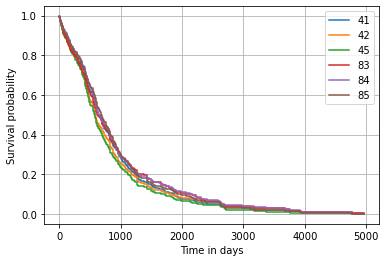

In [9]:
import matplotlib.pyplot as plt
liste_age = [41,42,45,83,84,85]
for i, s in enumerate(surv):
    plt.step(random_forest.event_times_, s, where="post", label=liste_age[i])
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)